# Goal 3: Calibration and Rectification

## 1. Imports and Configuration
Run this cell to load necessary libraries and define calibration settings.

In [1]:
import cv2
import numpy as np
import glob
import os
import random
from datetime import datetime
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
# ---------------------------------------------------------------------------
# CONFIGURATION
# ---------------------------------------------------------------------------
RELATIVE_RAW_DATASET_PATH = "../raw"
LEFT_IMG_PATH  = f"{RELATIVE_RAW_DATASET_PATH}/calib/image_02/data"
RIGHT_IMG_PATH = f"{RELATIVE_RAW_DATASET_PATH}/calib/image_03/data"

PROCESS_ALL_IMAGES = True 

MIN_BOARD_WIDTH_PX = 25
Y_MATCH_TOLERANCE  = 20.0 
RIGHT_X_OFFSET     = 50 

# RANSAC SETTINGS
RANSAC_ITERATIONS  = 100    
RANSAC_SAMPLE_SIZE = 6      
RANSAC_THRESHOLD   = 3.0    

boards = [
    {"name": "boardBig", "pattern_size": (11, 7), "square_size": 0.10},
    {"name": "boardMed", "pattern_size": (5, 7),  "square_size": 0.10}, 
    {"name": "boardTall", "pattern_size": (5, 15), "square_size": 0.10}
]

## 2. Helper Functions: Utilities & IO
Functions for file handling, image processing, and saving KITTI format.

In [2]:
def get_image_files(directory):
    if not os.path.exists(directory): return []
    files = sorted(glob.glob(os.path.join(directory, "*.png")))
    if not files: files = sorted(glob.glob(os.path.join(directory, "*.jpg")))
    return files

def sharpen_image(gray_img):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    return cv2.filter2D(gray_img, -1, kernel)

def force_top_left_start(corners):
    if (corners[0][0] + corners[0][1]) > (corners[-1][0] + corners[-1][1]):
        return corners[::-1]
    return corners

def get_object_points(nx, ny, square_size):
    objp = np.zeros((ny * nx, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
    return objp * square_size

def save_kitti_format(filename, img_shape, K1, D1, K2, D2, R, T, R1, R2, P1, P2):
    """
    Exports stereo calibration data to KITTI calib_cam_to_cam.txt format.
    """
    def to_str(arr):
        return " ".join(f"{x:.6e}" for x in arr.flatten())

    w, h = img_shape
    R_ident = np.eye(3, dtype=np.float64)
    T_zero  = np.zeros((3, 1), dtype=np.float64)

    cameras = {
        "00": {"S": (w,h), "K": K1, "D": D1, "R": R_ident, "T": T_zero, "R_rect": R1, "P_rect": P1},
        "01": {"S": (w,h), "K": K2, "D": D2, "R": R,       "T": T,      "R_rect": R2, "P_rect": P2},
        "02": {"S": (w,h), "K": K1, "D": D1, "R": R_ident, "T": T_zero, "R_rect": R1, "P_rect": P1},
        "03": {"S": (w,h), "K": K2, "D": D2, "R": R,       "T": T,      "R_rect": R2, "P_rect": P2},
    }

    calib_time = datetime.now().strftime("%d-%b-%Y %H:%M:%S")
    corner_dist = boards[0]["square_size"] 

    print(f"Writing calibration data to {filename}...")
    with open(filename, "w") as f:
        f.write(f"calib_time: {calib_time}\n")
        f.write(f"corner_dist: {corner_dist:.6e}\n")
        
        for cam_id in ["00", "01", "02", "03"]:
            c = cameras[cam_id]
            f.write(f"S_{cam_id}: {float(c['S'][0]):.6e} {float(c['S'][1]):.6e}\n")
            f.write(f"K_{cam_id}: {to_str(c['K'])}\n")
            f.write(f"D_{cam_id}: {to_str(c['D'])}\n")
            f.write(f"R_{cam_id}: {to_str(c['R'])}\n")
            f.write(f"T_{cam_id}: {to_str(c['T'])}\n")
            f.write(f"S_rect_{cam_id}: {float(c['S'][0]):.6e} {float(c['S'][1]):.6e}\n")
            f.write(f"R_rect_{cam_id}: {to_str(c['R_rect'])}\n")
            f.write(f"P_rect_{cam_id}: {to_str(c['P_rect'])}\n")

## 3. Helper Functions: Detection & Matching
Functions to detect multiple Charuco/Chessboard patterns and match them between left and right images.

In [3]:
def detect_boards_raw(img):
    gray_base = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_processing = sharpen_image(gray_base).copy()
    subpix_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.0001)
    detections = []

    for board in boards:
        name = board["name"]
        nx, ny = board["pattern_size"]
        sq_size = board["square_size"]
        
        while True:
            flags = cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_NORMALIZE_IMAGE
            ret, corners = cv2.findChessboardCorners(gray_processing, (nx, ny), flags)
            
            if not ret:
                gray_upscaled = cv2.resize(gray_processing, None, fx=2.0, fy=2.0, interpolation=cv2.INTER_CUBIC)
                ret, corners_up = cv2.findChessboardCorners(gray_upscaled, (nx, ny), flags)
                if ret: corners = corners_up / 2.0

            if ret:
                corners = corners.reshape(-1, 2).astype(np.float32)
                x,y,w,h = cv2.boundingRect(corners.astype(np.int32))
                if w < MIN_BOARD_WIDTH_PX: 
                    hull = cv2.convexHull(corners.astype(np.int32))
                    cv2.fillConvexPoly(gray_processing, hull, 0)
                    continue

                dist = np.linalg.norm(corners[0] - corners[1])
                radius = max(3, min(30, int(dist / 2.5)))
                cv2.cornerSubPix(gray_base, corners, (radius, radius), (-1, -1), subpix_criteria)
                
                cx, cy = np.mean(corners, axis=0).ravel()
                detections.append({
                    'name': name, 'centroid': (cx, cy),
                    'corners': corners, 'pattern_size': (nx, ny), 'square_size': sq_size
                })

                mask = np.zeros_like(gray_processing)
                hull = cv2.convexHull(corners.astype(np.int32))
                cv2.fillConvexPoly(mask, hull, 255)
                mask = cv2.dilate(mask, np.ones((15,15), np.uint8))
                gray_processing[mask > 0] = 0
            else:
                break 
    return detections

def match_boards_global(left_dets, right_dets):
    potential_matches = []
    for l_idx, l_det in enumerate(left_dets):
        lx, ly = l_det['centroid']
        for r_idx, r_det in enumerate(right_dets):
            if l_det['name'] != r_det['name']: continue
            rx, ry = r_det['centroid']
            rx_shifted = rx + RIGHT_X_OFFSET 
            dy = abs(ly - ry)
            dx = abs(lx - rx_shifted)
            if dy > Y_MATCH_TOLERANCE: continue
            score = (dy * 2.0) + dx 
            potential_matches.append({'score': score, 'l_idx': l_idx, 'r_idx': r_idx, 'l_det': l_det, 'r_det': r_det})
    potential_matches.sort(key=lambda x: x['score'])
    final_matches = []
    used_L, used_R = set(), set()
    for m in potential_matches:
        if m['l_idx'] not in used_L and m['r_idx'] not in used_R:
            final_matches.append((m['l_det'], m['r_det']))
            used_L.add(m['l_idx'])
            used_R.add(m['r_idx'])
    return final_matches

## 4. Step #01: Load & Detect
Iterates through all image pairs to find object points and image points.

Processing 19 image pairs...


/tmp/ipykernel_1714/2684877187.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('hsv', num_pairs + 1)


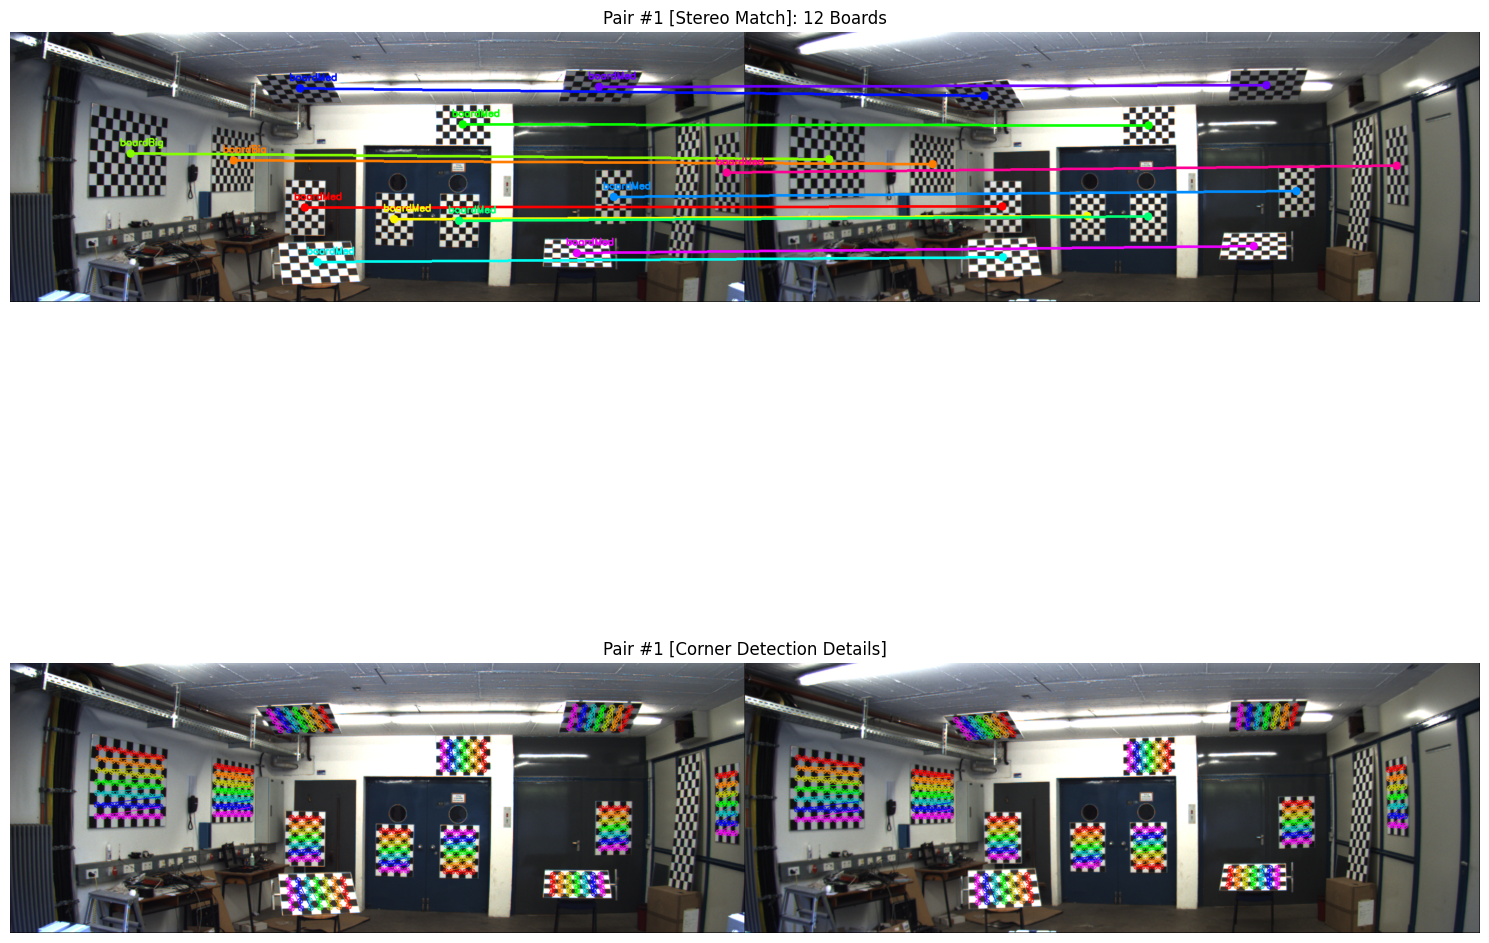

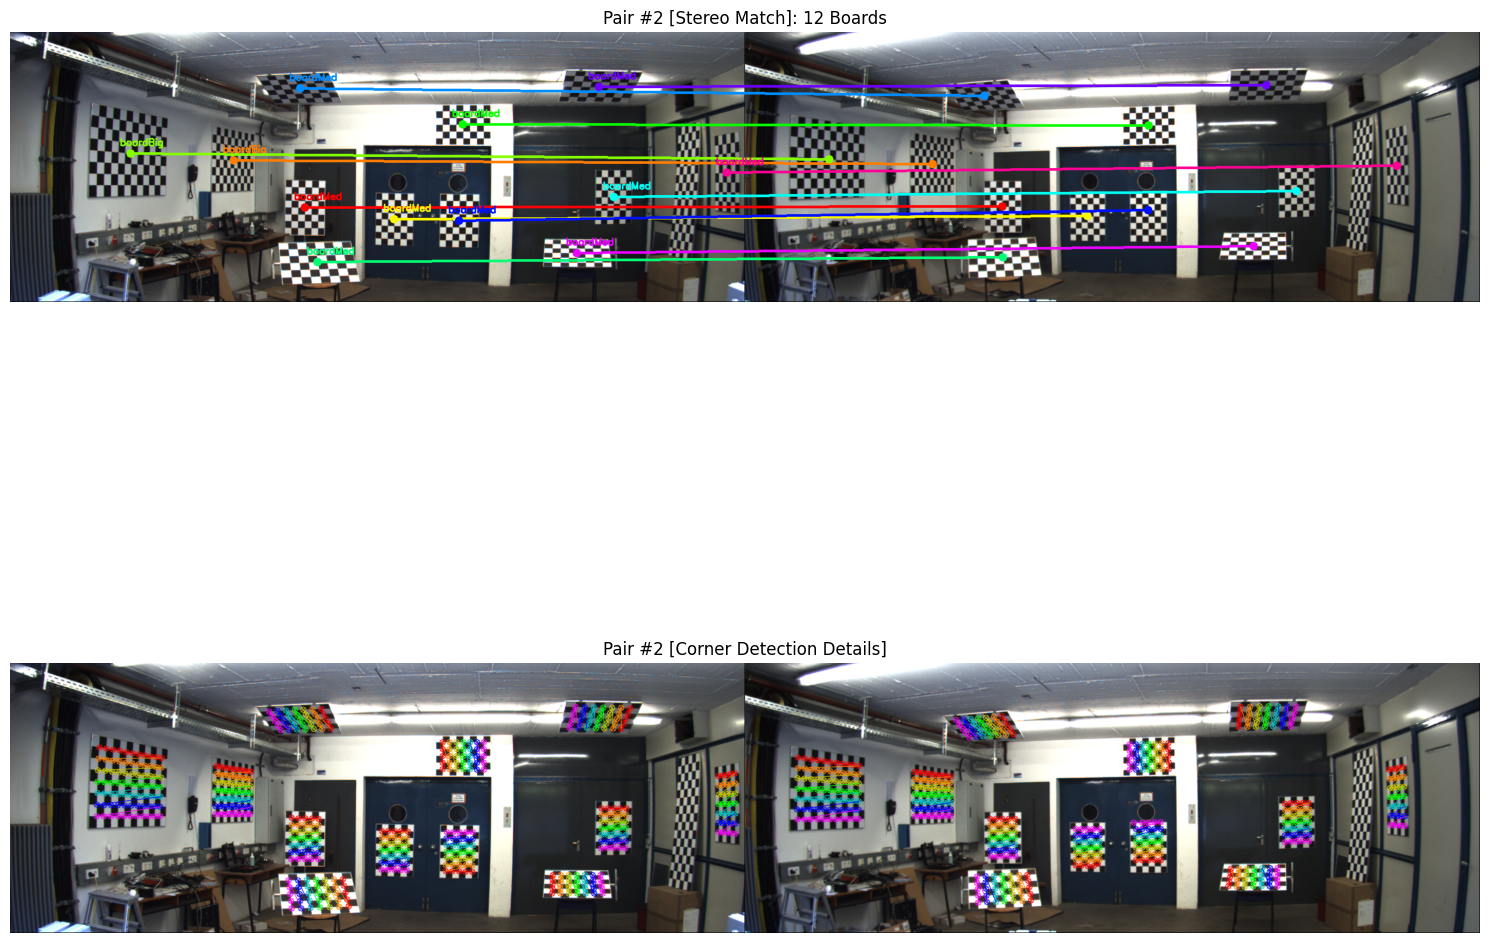

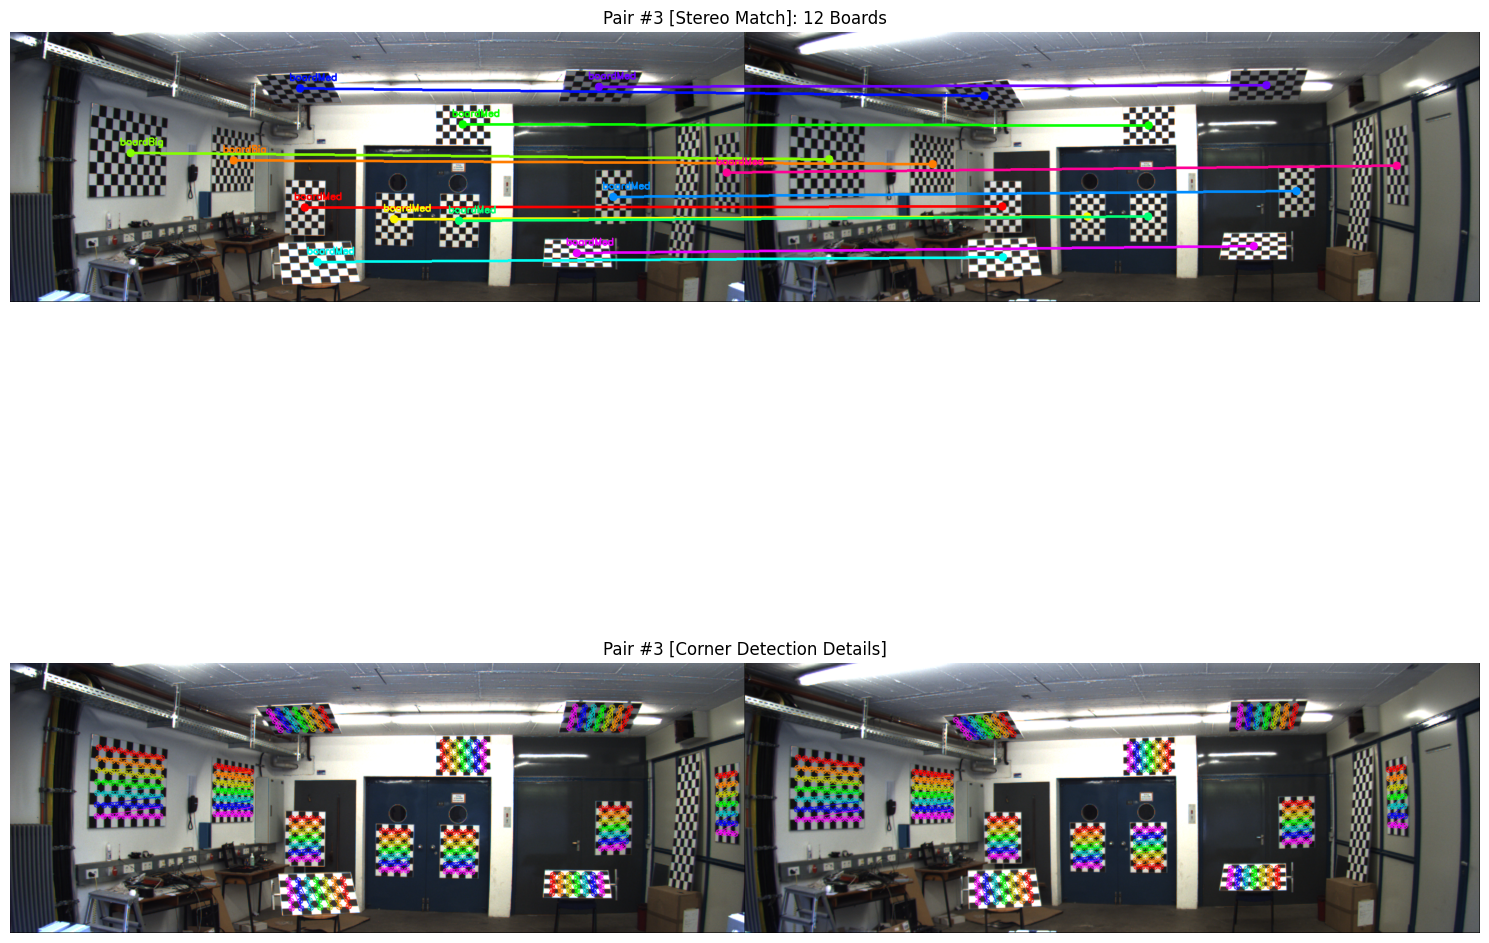

  Loaded 5/19 pairs...
  Loaded 10/19 pairs...
  Loaded 15/19 pairs...

Total Boards Found: 228


In [4]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import cv2
from concurrent.futures import ThreadPoolExecutor

# Ensure matplotlib is inline
%matplotlib inline 

left_files = get_image_files(LEFT_IMG_PATH)
right_files = get_image_files(RIGHT_IMG_PATH)
min_len = min(len(left_files), len(right_files))

objpoints, imgpoints_L, imgpoints_R = [], [], []
img_shape = None

# VISUALIZATION SETTINGS
VISUALIZE_FIRST_N_PAIRS = 3 

print(f"Processing {min_len} image pairs...")

executor = ThreadPoolExecutor(max_workers=2)

for i, (f_left, f_right) in enumerate(zip(left_files[:min_len], right_files[:min_len])):
    imgL = cv2.imread(f_left)
    imgR = cv2.imread(f_right)
    if imgL is None or imgR is None: continue
    if img_shape is None: img_shape = (imgL.shape[1], imgL.shape[0])

    # 1. Parallel Detection
    future_L = executor.submit(detect_boards_raw, imgL)
    future_R = executor.submit(detect_boards_raw, imgR)
    detsL = future_L.result()
    detsR = future_R.result()
    
    pairs = match_boards_global(detsL, detsR)

    # ========================================================================
    # VISUALIZATION START
    # ========================================================================
    if i < VISUALIZE_FIRST_N_PAIRS and len(pairs) > 0:
        width_L = imgL.shape[1]
        
        # --- PREP: Generate Colors ---
        num_pairs = len(pairs)
        color_map = cm.get_cmap('hsv', num_pairs + 1)

        # -----------------------------------------------------------
        # IMAGE 1: Stereo Connections (Centroids)
        # -----------------------------------------------------------
        vis_connect = np.hstack((imgL.copy(), imgR.copy()))
        
        for idx, (l_det, r_det) in enumerate(pairs):
            # Color Logic
            rgba = color_map(idx) 
            color = (int(rgba[2]*255), int(rgba[1]*255), int(rgba[0]*255))
            
            # Centroids
            cx_l, cy_l = map(int, l_det['centroid'])
            cx_r, cy_r = map(int, r_det['centroid'])
            cx_r_shifted = cx_r + width_L
            
            # Draw
            cv2.circle(vis_connect, (cx_l, cy_l), 8, color, -1)
            cv2.circle(vis_connect, (cx_r_shifted, cy_r), 8, color, -1)
            cv2.line(vis_connect, (cx_l, cy_l), (cx_r_shifted, cy_r), color, 3)
            cv2.putText(vis_connect, l_det['name'], (cx_l - 20, cy_l - 15), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        # -----------------------------------------------------------
        # IMAGE 2: Detailed Corner Detection
        # -----------------------------------------------------------
        # We work on individual copies first, then stack them
        vis_corn_L = imgL.copy()
        vis_corn_R = imgR.copy()

        for l_det, r_det in pairs:
            # OpenCV's built-in function to draw the rainbow pattern lines
            cv2.drawChessboardCorners(vis_corn_L, l_det['pattern_size'], l_det['corners'], True)
            cv2.drawChessboardCorners(vis_corn_R, r_det['pattern_size'], r_det['corners'], True)

        vis_corners = np.hstack((vis_corn_L, vis_corn_R))

        # -----------------------------------------------------------
        # DISPLAY BOTH
        # -----------------------------------------------------------
        # Create a figure with 2 rows, 1 column
        fig, axes = plt.subplots(2, 1, figsize=(15, 16))
        
        # Plot 1: Connections
        axes[0].imshow(cv2.cvtColor(vis_connect, cv2.COLOR_BGR2RGB))
        axes[0].set_title(f"Pair #{i+1} [Stereo Match]: {num_pairs} Boards")
        axes[0].axis('off')
        
        # Plot 2: Corners
        axes[1].imshow(cv2.cvtColor(vis_corners, cv2.COLOR_BGR2RGB))
        axes[1].set_title(f"Pair #{i+1} [Corner Detection Details]")
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()
    # ========================================================================

    for l_det, r_det in pairs:
        nx, ny = l_det['pattern_size']
        objpoints.append(get_object_points(nx, ny, l_det['square_size']))
        imgpoints_L.append(force_top_left_start(l_det['corners']))
        imgpoints_R.append(force_top_left_start(r_det['corners']))

    if (i+1) % 5 == 0: print(f"  Loaded {i+1}/{min_len} pairs...")
    if 'PROCESS_ALL_IMAGES' in locals() and not PROCESS_ALL_IMAGES and i > 0: break

executor.shutdown()

total_boards = len(objpoints)
if total_boards == 0: 
    print("No detections.")
else:
    print(f"\nTotal Boards Found: {total_boards}")

## 5. Step #02: Mono Calibration
Performs individual calibration for Left and Right cameras to get initial intrinsic guesses.

In [5]:
if total_boards > 0:
    print("\n>>> Running Mono Calibration (This provides poses for RANSAC)...")
    # Standard model: Fix K3 (radial distortion coefficient 3)
    calib_flags = cv2.CALIB_FIX_K3

    retL, K1, D1, rvecsL, tvecsL = cv2.calibrateCamera(objpoints, imgpoints_L, img_shape, None, None, flags=calib_flags)
    retR, K2, D2, rvecsR, tvecsR = cv2.calibrateCamera(objpoints, imgpoints_R, img_shape, None, None, flags=calib_flags)
    print(f"Mono RMS -> L: {retL:.3f} | R: {retR:.3f}")


>>> Running Mono Calibration (This provides poses for RANSAC)...
Mono RMS -> L: 0.220 | R: 0.265


## 6. Step #03: Fast RANSAC
Uses RANSAC to filter out outlier detections that do not satisfy stereo geometry.

In [6]:
def check_stereo_consistency(obj_pts, img_pts_R, rvecL, tvecL, K2, D2, R_stereo, T_stereo):
    # 1. Transform Object Points to Left Camera Coordinate System
    R_mono, _ = cv2.Rodrigues(rvecL)
    P_left = (R_mono @ obj_pts.T.astype(np.float64)).T + tvecL.T 

    # 2. Transform Left Camera Points to Right Camera Coordinate System
    P_right = (R_stereo @ P_left.T).T + T_stereo.T

    # 3. Project to Right Image Plane
    img_pts_proj, _ = cv2.projectPoints(P_right, np.zeros(3), np.zeros(3), K2, D2)
    
    # Cast to float32 for consistency check
    img_pts_proj = img_pts_proj.reshape(-1, 2).astype(np.float32)
    
    # 4. Calculate Error
    error = cv2.norm(img_pts_R, img_pts_proj, cv2.NORM_L2) / np.sqrt(len(img_pts_R))
    return error

if total_boards > 0:
    print(f"\n>>> Running Fast RANSAC ({RANSAC_ITERATIONS} iterations)...")
    
    # Standard model for RANSAC
    stereo_flags_fixed = cv2.CALIB_FIX_INTRINSIC | cv2.CALIB_FIX_K3
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-4)

    best_score = 0 
    best_inliers_idx = []
    
    all_indices = list(range(total_boards))

    for it in range(RANSAC_ITERATIONS):
        sample_idxs = random.sample(all_indices, RANSAC_SAMPLE_SIZE)
        
        try:
            _, _,_,_,_, R_hyp, T_hyp, _, _ = cv2.stereoCalibrate(
                [objpoints[k] for k in sample_idxs], 
                [imgpoints_L[k] for k in sample_idxs], 
                [imgpoints_R[k] for k in sample_idxs], 
                K1, D1, K2, D2, img_shape, criteria=criteria, flags=stereo_flags_fixed
            )
        except:
            continue

        current_inliers = []
        
        for k in all_indices:
            err = check_stereo_consistency(
                objpoints[k], imgpoints_R[k], 
                rvecsL[k], tvecsL[k], 
                K2, D2, R_hyp, T_hyp
            )
            if err < RANSAC_THRESHOLD:
                current_inliers.append(k)

        count = len(current_inliers)
        if count > best_score:
            best_score = count
            best_inliers_idx = current_inliers
            print(f"  [Iter {it}] New Best: {count}/{total_boards} inliers.")

    print(f"\nRANSAC Complete. Kept {len(best_inliers_idx)} boards.")


>>> Running Fast RANSAC (100 iterations)...
  [Iter 0] New Best: 114/228 inliers.
  [Iter 1] New Best: 132/228 inliers.
  [Iter 14] New Best: 151/228 inliers.
  [Iter 35] New Best: 158/228 inliers.
  [Iter 85] New Best: 163/228 inliers.
  [Iter 88] New Best: 170/228 inliers.

RANSAC Complete. Kept 170 boards.


## 7. Step #04: Final Refinement & Export
Runs the final Stereo Calibration optimization using only the inliers, calculates rectification, and saves to KITTI format.

In [7]:
if total_boards > 0 and best_inliers_idx:
    print(">>> Final Optimization using Inliers...")
    final_obj = [objpoints[k] for k in best_inliers_idx]
    final_L   = [imgpoints_L[k] for k in best_inliers_idx]
    final_R   = [imgpoints_R[k] for k in best_inliers_idx]

    final_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-5)

    final_flags = cv2.CALIB_USE_INTRINSIC_GUESS | \
                  cv2.CALIB_FIX_ASPECT_RATIO | \
                  cv2.CALIB_ZERO_TANGENT_DIST | \
                  cv2.CALIB_FIX_K3 | \
                  cv2.CALIB_FIX_PRINCIPAL_POINT 

    retS, K1, D1, K2, D2, R, T, E, F = cv2.stereoCalibrate(
        final_obj, final_L, final_R,
        K1, D1, K2, D2,
        img_shape,
        criteria=final_criteria,
        flags=final_flags 
    )

    print(f"\nFINAL STEREO RMS: {retS:.4f} px")
    print(f"Baseline (T x): {T[0][0]:.4f}")
    print(f"New Focal Length (fx): {K1[0][0]:.4f}")

    # --- RECTIFICATION & EXPORT ---
    print("\n>>> Calculating Rectification Transforms...")
    R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
        K1, D1, K2, D2, img_shape, R, T, flags=cv2.CALIB_ZERO_DISPARITY, alpha=0
    )

    # EXPORT TO KITTI FILE
    save_kitti_format("calib_cam_to_cam.txt", img_shape, K1, D1, K2, D2, R, T, R1, R2, P1, P2)

>>> Final Optimization using Inliers...



FINAL STEREO RMS: 0.3190 px
Baseline (T x): -0.5549
New Focal Length (fx): 1019.2339

>>> Calculating Rectification Transforms...
Writing calibration data to calib_cam_to_cam.txt...


## 8. Step #05: Visualization
Visualizes the rectified images. Press **ESC** to stop.


>>> Visualizing Rectification (Showing first pair)...


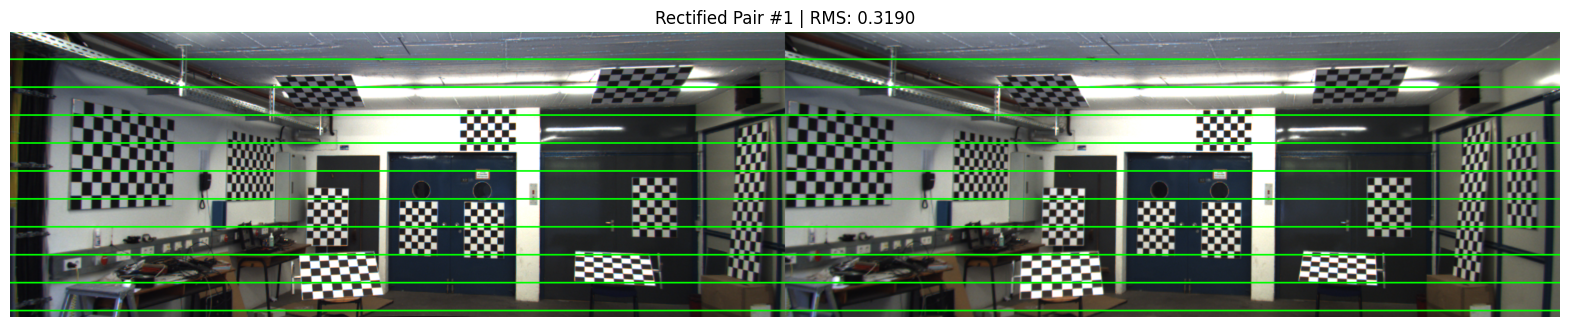

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

if total_boards > 0 and best_inliers_idx:
    print("\n>>> Visualizing Rectification (Showing first pair)...")
    
    # Initialize Rectification Maps
    map1x, map1y = cv2.initUndistortRectifyMap(K1, D1, R1, P1, img_shape, cv2.CV_32FC1)
    map2x, map2y = cv2.initUndistortRectifyMap(K2, D2, R2, P2, img_shape, cv2.CV_32FC1)

    # Limit visualization to first pair to avoid flooding the notebook
    files_to_show = list(zip(left_files, right_files))[:1]

    for i, (f_left, f_right) in enumerate(files_to_show):
        imgL = cv2.imread(f_left)
        imgR = cv2.imread(f_right)
        if imgL is None or imgR is None: continue

        # 1. Rectify images
        rectL = cv2.remap(imgL, map1x, map1y, cv2.INTER_LINEAR)
        rectR = cv2.remap(imgR, map2x, map2y, cv2.INTER_LINEAR)

        # 2. Combine side-by-side
        combined = np.hstack((rectL, rectR))

        # 3. Draw horizontal green lines to check alignment
        # If calibrated correctly, features should align on these lines
        for y in range(0, combined.shape[0], 50):
            cv2.line(combined, (0, y), (combined.shape[1], y), (0, 255, 0), 2)

        # 4. Convert BGR (OpenCV) to RGB (Matplotlib)
        combined_rgb = cv2.cvtColor(combined, cv2.COLOR_BGR2RGB)

        # 5. Plot
        plt.figure(figsize=(20, 10))
        plt.imshow(combined_rgb)
        plt.title(f"Rectified Pair #{i+1} | RMS: {retS:.4f}")
        plt.axis("off")
        plt.show()